# Diffusers

#### Understanding pipelines, models and schedulers

https://huggingface.co/docs/diffusers/main/en/using-diffusers/write_own_pipeline


Diffusers provides state-of-the-art pretrained diffusion models across multiple modalities. Its purpose is to serve as a modular toolbox for both inference and training.

In [1]:
#!pip install torch
#!pip install diffusers

In [1]:
import numpy as np
import torch
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from PIL import Image

In [2]:
device = "cpu"

In [3]:
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256").to(device)

Set the number of timesteps to run the denoising process for:

In [4]:
scheduler.set_timesteps(50)

Setting the scheduler timesteps creates a tensor with evenly spaced elements in it, 50 in this example. Each element corresponds to a timestep at which the model denoises an image. When you create the denoising loop later, you’ll iterate over this tensor to denoise an image:

In [5]:
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

Create some random noise with the same shape as the desired output:

In [6]:
sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to(device)

Now write a loop to iterate over the timesteps. At each timestep, the model does a UNet2DModel.forward() pass and returns the noisy residual. The scheduler’s step() method takes the noisy residual, timestep, and input and it predicts the image at the previous timestep. This output becomes the next input to the model in the denoising loop, and it’ll repeat until it reaches the end of the timesteps array.

In [7]:
input = noise
for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample

    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

The last step is to convert the denoised output into an image:

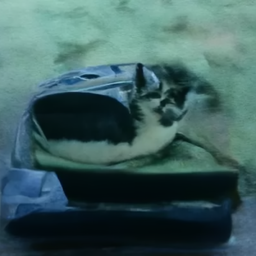

In [9]:
image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image

### DDPM Pipeline

A pipeline is a quick and easy way to run a model for inference, requiring no more than four lines of code to generate an image. Often times, you have to run the DiffusionPipeline several times before you end up with an image you’re happy with. 

  0%|          | 0/25 [00:00<?, ?it/s]

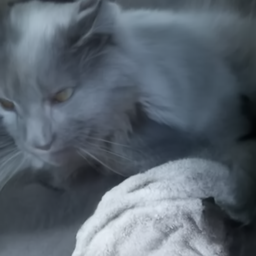

In [14]:
ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256").to(device)
image = ddpm(num_inference_steps=25).images[0]
image